## 1. Reading Data From CSV File

In [2]:
import pandas as pd

df = pd.read_csv("cs_deep_learning_qa_detailed.csv")
print(f"Totally we have {len(df)} questions.")
df.head()

Totally we have 96 questions.


,Question,Answer
0,What is the typical structure of a deep learni...,A typical deep learning research paper include...
1,How should I write an effective abstract for a...,An effective abstract should concisely summari...
2,What are some best practices for writing the i...,"Begin with a clear motivation, define the prob..."
3,How to structure the related work section in a...,Organize related work either thematically or c...
4,What are key considerations when selecting dat...,"Choose datasets that are representative, diver..."


## 2. Training the model & Tune the top_p
### 2.1 top_p=1.0

In [3]:
import requests

def ask_ollama(prompt, model="llama2", temperature=0, top_p=0, max_tokens=20):
    url = "http://localhost:11434/api/chat"
    headers = {'Content-Type': 'application/json'}

    short_prompt = "Given that you are a researcher " + prompt.strip() + " Please keep your answer as concise as one or two sentences."

    payload = {
        "model": model,
        "messages": [
            {"role": "user", "content": short_prompt}
        ],
        "temperature": temperature,
        "top_p": top_p,
        "repeat_penalty": 1.1,
        "stream": False,
        "num_predict": max_tokens
    }

    response = requests.post(url, json=payload, headers=headers)
    
    if response.status_code != 200:
        print("Error:", response.text)
        return ""

    result = response.json()["message"]["content"].strip()
    print(f"Prompt: {prompt}")
    print(f"Generated: {result}\n")
    return result

In [4]:
df_trial = df.copy()

import os

from bert_score import BERTScorer
from concurrent.futures import ThreadPoolExecutor

with ThreadPoolExecutor(max_workers=8) as executor:
    df_trial["generated_default"] = list(executor.map(ask_ollama, df_trial["Question"]))

print("Loading BERTScorer with bert-base-uncased ...")
scorer = BERTScorer(
    model_type="bert-base-uncased", 
    lang="en",
    rescale_with_baseline=True
)
print("BERTScorer loaded.\n")

def score_and_print(ref, pred):
    _, _, F1 = scorer.score([pred], [ref])
    f1_score = F1[0].item()
    print(f"Ref: {ref}")
    print(f"Pred: {pred}")
    print(f"BERTScore F1: {f1_score:.4f}\n")
    return f1_score

df_trial["bertscore_default"] = [
    score_and_print(ref, gen)
    for ref, gen in zip(df_trial["Answer"], df_trial["generated_default"])
]

Prompt: How can I evaluate my deep learning model's performance effectively?
Generated: To evaluate the performance of a deep learning model effectively, use a combination of metrics tailored to the specific task and dataset, such as accuracy, precision, recall, F1 score, and AUC-ROC. Additionally, consider using techniques like cross-validation and grid search to optimize hyperparameters and improve generalization.

Prompt: What are key considerations when selecting datasets for deep learning research?
Generated: When selecting datasets for deep learning research, key considerations include the size and diversity of the dataset, the quality and representativeness of the data, the availability of relevant annotations or labels, and the potential for the dataset to be easily generalizable to new situations or environments. Additionally, it is important to evaluate the dataset's bias and ensure that it does not perpetuate any existing inequalities or discrimination.

Prompt: How to struc

In [5]:
df_trial.head()

,Question,Answer,generated_default,bertscore_default
0,What is the typical structure of a deep learni...,A typical deep learning research paper include...,A typical structure of a deep learning researc...,0.577377
1,How should I write an effective abstract for a...,An effective abstract should concisely summari...,To write an effective abstract for a computer ...,0.386640
2,What are some best practices for writing the i...,"Begin with a clear motivation, define the prob...","As a researcher, some best practices for writi...",0.317167
3,How to structure the related work section in a...,Organize related work either thematically or c...,To structure the related work section in a mac...,0.315999
4,What are key considerations when selecting dat...,"Choose datasets that are representative, diver...",When selecting datasets for deep learning rese...,0.351386


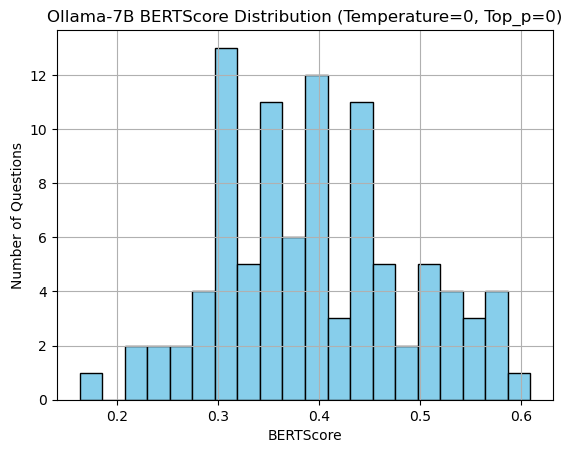

In [6]:
import matplotlib.pyplot as plt

plt.hist(df_trial["bertscore_default"], bins=20, color='skyblue', edgecolor='black')
plt.title("Ollama-7B BERTScore Distribution (Temperature=0, Top_p=0)")
plt.xlabel("BERTScore")
plt.ylabel("Number of Questions")
plt.grid(True)
plt.show()

### 2.2 top_p=0.7

In [7]:
from functools import partial
from concurrent.futures import ThreadPoolExecutor

custom_ask = partial(ask_ollama, top_p=0.7)

with ThreadPoolExecutor(max_workers=8) as executor:
    df_trial["generated_topp07"] = list(executor.map(custom_ask, df_trial["Question"]))

df_trial["bertscore_topp07"] = [
    score_and_print(ref, gen)
    for ref, gen in zip(df_trial["Answer"], df_trial["generated_topp07"])
]

Prompt: What is the typical structure of a deep learning research paper?
Generated: A typical structure of a deep learning research paper includes an introduction, literature review, methodology, results, discussion, and conclusion. The introduction provides background information and motivation for the study, while the literature review surveys existing work in the field. The methodology section describes the dataset, models, and algorithms used, and the results section presents the findings of the study. The discussion section interprets the results and compares them to related work, and the conclusion summarizes the main findings and future directions.

Prompt: How do I write reproducible deep learning experiments?
Generated: To write reproducible deep learning experiments, use version control systems such as Git to track changes to your code and data, and incorporate consistent naming conventions, documentation, and testing practices throughout your workflow. Additionally, leverage

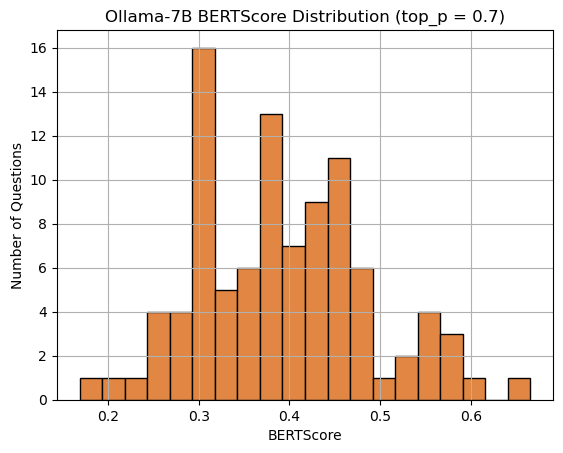

In [8]:
import matplotlib.pyplot as plt

plt.hist(df_trial["bertscore_topp07"], bins=20, color='#e28743', edgecolor='black')
plt.title("Ollama-7B BERTScore Distribution (top_p = 0.7)")
plt.xlabel("BERTScore")
plt.ylabel("Number of Questions")
plt.grid(True)
plt.show()

### 2.3 top_p=0.3

In [9]:
from functools import partial
from concurrent.futures import ThreadPoolExecutor

custom_ask = partial(ask_ollama, top_p=0.3)

with ThreadPoolExecutor(max_workers=8) as executor:
    df_trial["generated_topp03"] = list(executor.map(custom_ask, df_trial["Question"]))

df_trial["bertscore_topp03"] = [
    score_and_print(ref, gen)
    for ref, gen in zip(df_trial["Answer"], df_trial["generated_topp03"])
]

Prompt: What are some best practices for writing the introduction of a deep learning paper?
Generated: As a researcher, some best practices for writing the introduction of a deep learning paper include:

1. Start with a clear and concise statement of the problem or question being addressed, and explain why it is important or interesting.
2. Provide context and background information to help readers understand the significance of the work and its relevance to existing research in the field.

Prompt: How should I write an effective abstract for a CS research paper?
Generated: To write an effective abstract for a CS research paper, focus on providing a clear and concise summary of your research contribution, highlighting the problem you addressed, the approach you took, and the key findings or results. Keep it brief and to the point, aiming for around 150-200 words in length.

Prompt: What are key considerations when selecting datasets for deep learning research?
Generated: When selecting

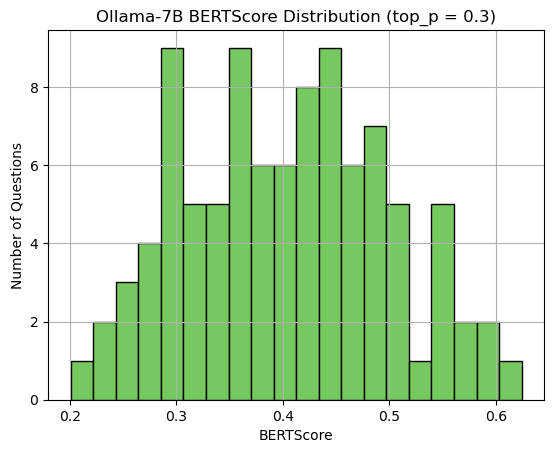

In [10]:
plt.hist(df_trial["bertscore_topp03"], bins=20, color='#76c960', edgecolor='black')
plt.title("Ollama-7B BERTScore Distribution (top_p = 0.3)")
plt.xlabel("BERTScore")
plt.ylabel("Number of Questions")
plt.grid(True)
plt.show()

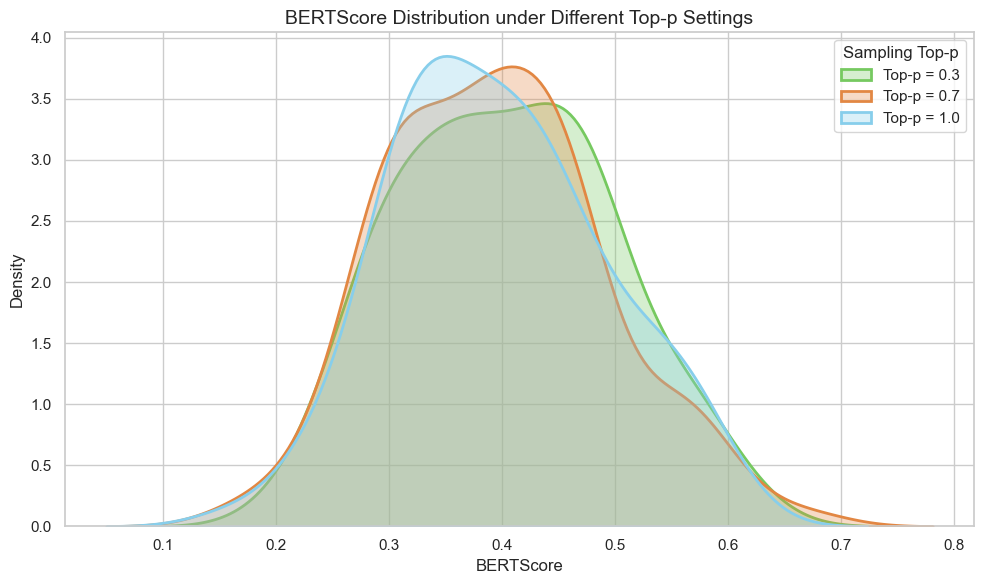

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))

sns.kdeplot(df_trial["bertscore_topp03"], label="Top-p = 0.3", linewidth=2, fill=True, alpha=0.3, color="#76c960")
sns.kdeplot(df_trial["bertscore_topp07"], label="Top-p = 0.7", linewidth=2, fill=True, alpha=0.3, color='#e28743')
sns.kdeplot(df_trial["bertscore_default"], label="Top-p = 1.0", linewidth=2, fill=True, alpha=0.3, color='skyblue')

plt.title("BERTScore Distribution under Different Top-p Settings", fontsize=14)
plt.xlabel("BERTScore", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(title="Sampling Top-p")
plt.tight_layout()
plt.grid(True)

plt.show()

## 3. Tune the temperature

In [12]:
from functools import partial
from concurrent.futures import ThreadPoolExecutor

custom_ask = partial(ask_ollama, temperature=0.7)

with ThreadPoolExecutor(max_workers=8) as executor:
    df_trial["generated_temp07"] = list(executor.map(custom_ask, df_trial["Question"]))

df_trial["bertscore_temp07"] = [
    score_and_print(ref, gen)
    for ref, gen in zip(df_trial["Answer"], df_trial["generated_temp07"])
]

Prompt: What are key considerations when selecting datasets for deep learning research?
Generated: When selecting datasets for deep learning research, key considerations include the size and diversity of the dataset, the quality and representativeness of the data, and the availability of relevant metadata and annotations. Additionally, the dataset should align with the research question and objectives, and the methodology used to preprocess and transform the data should be appropriate for the task at hand.

Prompt: What is an ablation study and how should it be conducted?
Generated: An ablation study in machine learning research involves systematically modifying a model or component to understand its contribution to overall performance. The goal is to identify the most critical elements of the model that are responsible for its good or poor performance. To conduct an ablation study, researchers typically remove or "ablate" certain components of the model and evaluate the resulting perf

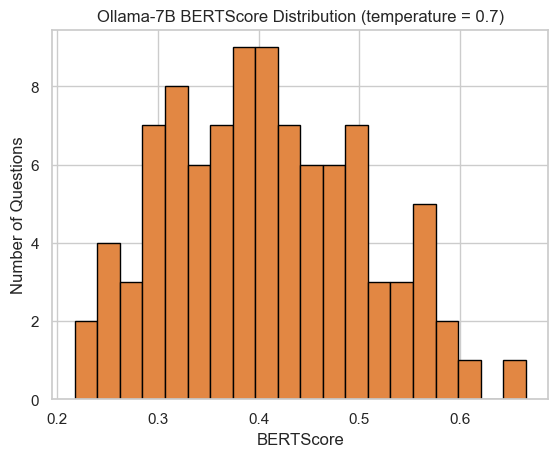

In [13]:
plt.hist(df_trial["bertscore_temp07"], bins=20, color='#e28743', edgecolor='black')
plt.title("Ollama-7B BERTScore Distribution (temperature = 0.7)")
plt.xlabel("BERTScore")
plt.ylabel("Number of Questions")
plt.grid(True)
plt.show()

In [14]:
from functools import partial
from concurrent.futures import ThreadPoolExecutor

custom_ask = partial(ask_ollama, temperature=0.3)

with ThreadPoolExecutor(max_workers=8) as executor:
    df_trial["generated_temp03"] = list(executor.map(custom_ask, df_trial["Question"]))

df_trial["bertscore_temp03"] = [
    score_and_print(ref, gen)
    for ref, gen in zip(df_trial["Answer"], df_trial["generated_temp03"])
]

Prompt: What are key considerations when selecting datasets for deep learning research?
Generated: When selecting datasets for deep learning research, key considerations include the size and diversity of the dataset, the quality and provenance of the data, the representation of the data (e.g., images, text, time-series), and the availability of relevant annotations or labels. Additionally, ensuring that the dataset is publicly available, open-source, and has a clear licensing agreement can be important factors in selecting datasets for deep learning research.

Prompt: How should I write an effective abstract for a CS research paper?
Generated: To write an effective abstract for a computer science (CS) research paper, focus on providing a clear and concise summary of the main contributions, methodology, and findings of your work. Use language that is accessible to a broad audience, avoiding technical jargon and including relevant keywords from your field. A well-crafted abstract should 

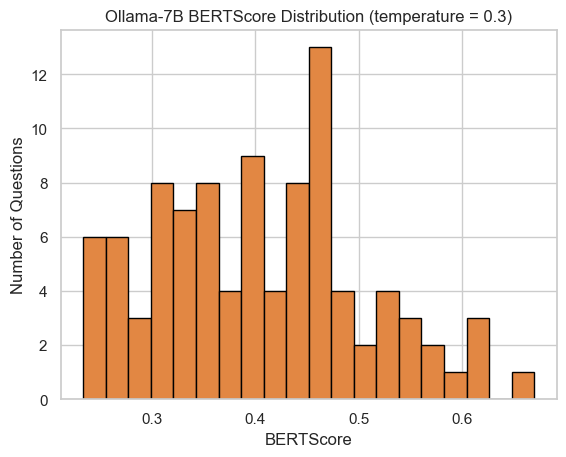

In [15]:
plt.hist(df_trial["bertscore_temp03"], bins=20, color='#e28743', edgecolor='black')
plt.title("Ollama-7B BERTScore Distribution (temperature = 0.3)")
plt.xlabel("BERTScore")
plt.ylabel("Number of Questions")
plt.grid(True)
plt.show()

### 3.3 Histogram of model output results at different temperatures

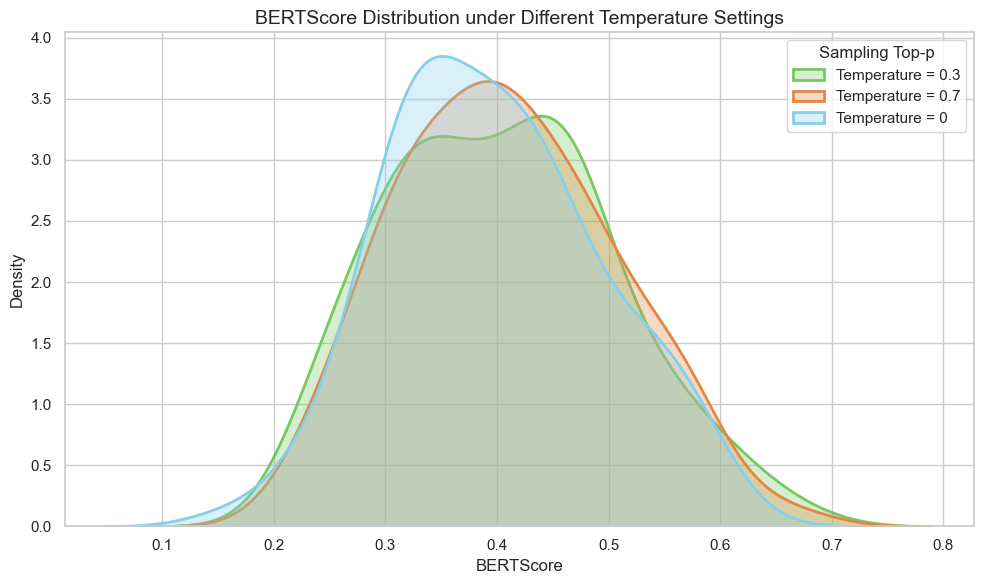

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))

sns.kdeplot(df_trial["bertscore_temp03"], label="Temperature = 0.3", linewidth=2, fill=True, alpha=0.3, color="#76c960")
sns.kdeplot(df_trial["bertscore_temp07"], label="Temperature = 0.7", linewidth=2, fill=True, alpha=0.3, color='#e28743')
sns.kdeplot(df_trial["bertscore_default"], label="Temperature = 0", linewidth=2, fill=True, alpha=0.3, color='skyblue')

plt.title("BERTScore Distribution under Different Temperature Settings", fontsize=14)
plt.xlabel("BERTScore", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(title="Sampling Top-p")
plt.tight_layout()
plt.grid(True)

plt.show()

## 4. Finding the optimal parameter combination

### 4.1 top_p = 0.7, temperature = 0.7

In [17]:
custom_ask = partial(ask_ollama, temperature=0.7, top_p=0.7)

with ThreadPoolExecutor(max_workers=8) as executor:
    df_trial["generated_temp07_topp07"] = list(executor.map(custom_ask, df_trial["Question"]))

df_trial["bertscore_temp07_topp07"] = [
    score_and_print(ref, gen)
    for ref, gen in zip(df_trial["Answer"], df_trial["generated_temp07_topp07"])
]

Prompt: How should I write an effective abstract for a CS research paper?
Generated: To write an effective abstract for a computer science (CS) research paper, focus on conveying the significance and key findings of your work in a clear and concise manner. Aim to provide enough context and background information to allow readers to understand the purpose and scope of your research, while also highlighting the novel contributions and practical implications of your work.

Prompt: How can I evaluate my deep learning model's performance effectively?
Generated: Effective evaluation of a deep learning model's performance involves measuring metrics such as accuracy, precision, recall, F1 score, or AUC-ROC, depending on the task at hand. These metrics provide insights into how well the model is able to make predictions or classify inputs, and can be used to compare the performance of different models or to monitor the performance of a single model over time.

Prompt: How to structure the relat

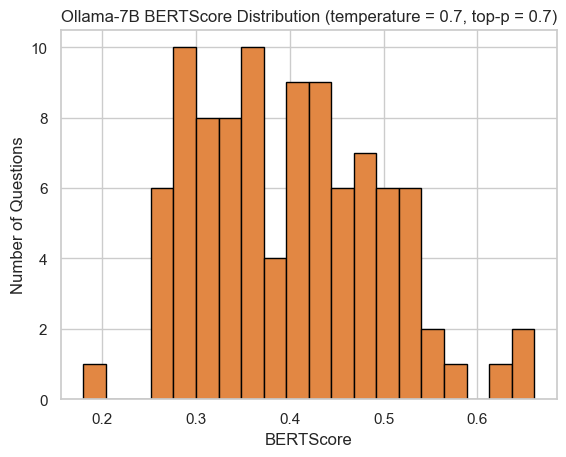

In [18]:
plt.hist(df_trial["bertscore_temp07_topp07"], bins=20, color='#e28743', edgecolor='black')
plt.title("Ollama-7B BERTScore Distribution (temperature = 0.7, top-p = 0.7)")
plt.xlabel("BERTScore")
plt.ylabel("Number of Questions")
plt.grid(True)
plt.show()

### 4.2 top_p = 0.3, temperature = 0.3

In [19]:
custom_ask = partial(ask_ollama, temperature=0.3, top_p=0.3)

with ThreadPoolExecutor(max_workers=8) as executor:
    df_trial["generated_temp03_topp03"] = list(executor.map(custom_ask, df_trial["Question"]))

df_trial["bertscore_temp03_topp03"] = [
    score_and_print(ref, gen)
    for ref, gen in zip(df_trial["Answer"], df_trial["generated_temp03_topp03"])
]

Prompt: What are some best practices for writing the introduction of a deep learning paper?
Generated: As a researcher, some best practices for writing the introduction of a deep learning paper include:

1. Providing context and background information on the problem you are addressing, highlighting its significance and relevance to the field.
2. Clearly stating the research question or hypothesis, and outlining the objectives and scope of the paper.

Prompt: How should I write an effective abstract for a CS research paper?
Generated: To write an effective abstract for a computer science (CS) research paper, focus on capturing the main contribution, methodology, and results of your work in a clear and concise manner. Aim to provide a brief overview of the key findings and their significance, while avoiding unnecessary detail or jargon.

Prompt: What is the typical structure of a deep learning research paper?
Generated: A typical structure for a deep learning research paper includes an i

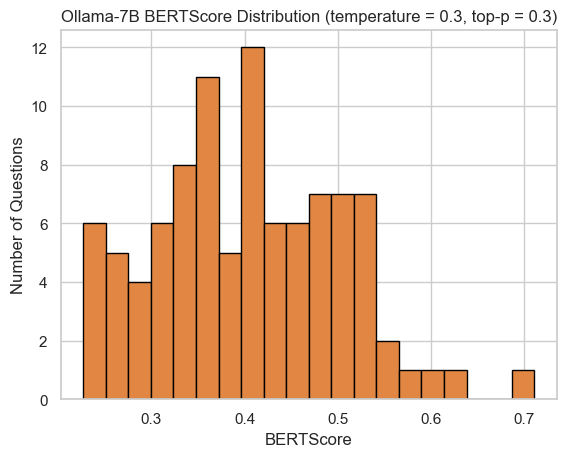

In [20]:
plt.hist(df_trial["bertscore_temp03_topp03"], bins=20, color='#e28743', edgecolor='black')
plt.title("Ollama-7B BERTScore Distribution (temperature = 0.3, top-p = 0.3)")
plt.xlabel("BERTScore")
plt.ylabel("Number of Questions")
plt.grid(True)
plt.show()

### 4.3 top_p = 0, temperature = 1

In [21]:
custom_ask = partial(ask_ollama, temperature=1, top_p=0)

with ThreadPoolExecutor(max_workers=8) as executor:
    df_trial["generated_temp1_topp0"] = list(executor.map(custom_ask, df_trial["Question"]))

df_trial["bertscore_temp1_topp0"] = [
    score_and_print(ref, gen)
    for ref, gen in zip(df_trial["Answer"], df_trial["generated_temp1_topp0"])
]

Prompt: How can I evaluate my deep learning model's performance effectively?
Generated: To evaluate the performance of a deep learning model effectively, consider using metrics that align with your task objectives and validate the model's predictions against ground truth data. Additionally, perform cross-validation to ensure the model's performance is not overfitting or underfitting the training data.

Prompt: How to structure the related work section in a machine learning paper?
Generated: To structure the related work section in a machine learning paper, first identify the key themes and subtopics within the field of interest, and then organize the literature review around these themes. This can involve dividing the section into subsections for different areas of research, such as algorithmic developments, applications in specific domains, or critical analyses of particular techniques. Each subsection should provide a comprehensive overview of the relevant literature, highlighting th

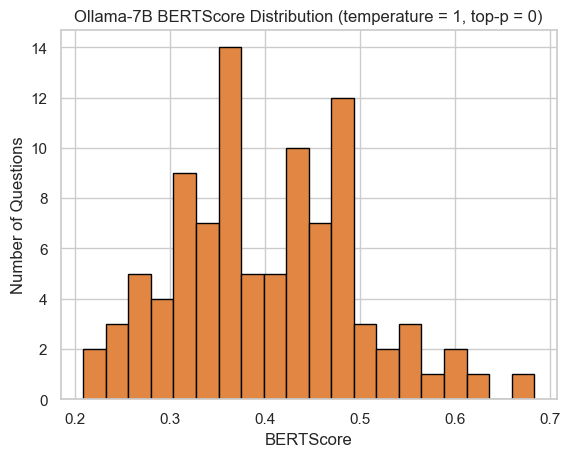

In [22]:
plt.hist(df_trial["bertscore_temp1_topp0"], bins=20, color='#e28743', edgecolor='black')
plt.title("Ollama-7B BERTScore Distribution (temperature = 1, top-p = 0)")
plt.xlabel("BERTScore")
plt.ylabel("Number of Questions")
plt.grid(True)
plt.show()

### 4.4 top_p = 1, temperature = 0

In [23]:
custom_ask = partial(ask_ollama, temperature=0, top_p=1)

with ThreadPoolExecutor(max_workers=8) as executor:
    df_trial["generated_temp0_topp1"] = list(executor.map(custom_ask, df_trial["Question"]))

df_trial["bertscore_temp0_topp1"] = [
    score_and_print(ref, gen)
    for ref, gen in zip(df_trial["Answer"], df_trial["generated_temp0_topp1"])
]

Prompt: How should I write an effective abstract for a CS research paper?
Generated: To write an effective abstract for a CS research paper, focus on clearly and concisely conveying the key contributions, methodology, and findings of your work. Aim for a length of around 150-250 words, and use simple language that is easily understandable by a broad audience.

Prompt: What is the typical structure of a deep learning research paper?
Generated: A typical structure of a deep learning research paper includes an introduction, literature review, methodology, results, discussion, and conclusion sections. The introduction provides background information and motivation for the research, while the literature review surveys existing work in the field. The methodology section describes the proposed model and its implementation, while the results section presents the findings of the research. The discussion section interprets the results and compares them to relevant works, and the conclusion secti

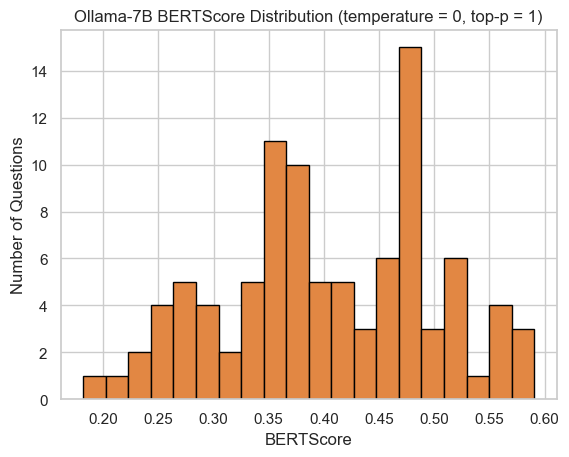

In [24]:
plt.hist(df_trial["bertscore_temp0_topp1"], bins=20, color='#e28743', edgecolor='black')
plt.title("Ollama-7B BERTScore Distribution (temperature = 0, top-p = 1)")
plt.xlabel("BERTScore")
plt.ylabel("Number of Questions")
plt.grid(True)
plt.show()

In [25]:
df_trial.to_csv("llama2_cs_dl_qa_finetuned.csv", index=False)

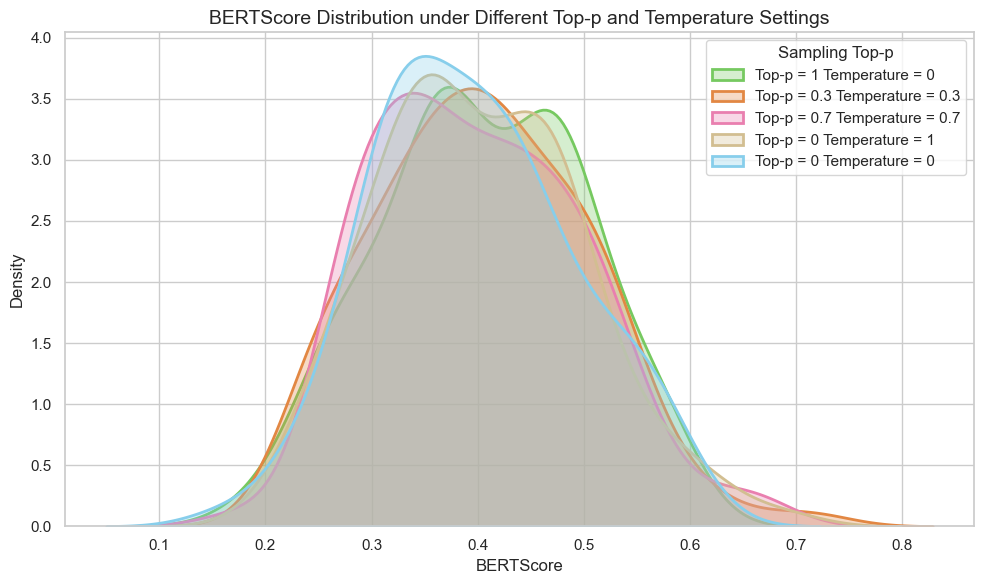

In [26]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))

sns.kdeplot(df_trial["bertscore_temp0_topp1"], label="Top-p = 1 Temperature = 0", linewidth=2, fill=True, alpha=0.3, color="#76c960")
sns.kdeplot(df_trial["bertscore_temp03_topp03"], label="Top-p = 0.3 Temperature = 0.3", linewidth=2, fill=True, alpha=0.3, color='#e28743')
sns.kdeplot(df_trial["bertscore_temp07_topp07"], label="Top-p = 0.7 Temperature = 0.7", linewidth=2, fill=True, alpha=0.3, color='#e97faf')
sns.kdeplot(df_trial["bertscore_temp1_topp0"], label="Top-p = 0 Temperature = 1", linewidth=2, fill=True, alpha=0.3, color='#d2be91')
sns.kdeplot(df_trial["bertscore_default"], label="Top-p = 0 Temperature = 0", linewidth=2, fill=True, alpha=0.3, color='skyblue')

plt.title("BERTScore Distribution under Different Top-p and Temperature Settings", fontsize=14)
plt.xlabel("BERTScore", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(title="Sampling Top-p")
plt.tight_layout()
plt.grid(True)

plt.show()

## 5. Other parameters to tune

### 5.1 Adjust the value of max_tokens parameter
* max_tokens=30

In [27]:
custom_ask = partial(ask_ollama, temperature=0.7, top_p=0.7, max_tokens=30)

with ThreadPoolExecutor(max_workers=8) as executor:
    df_trial["generated_max_tokens30"] = list(executor.map(custom_ask, df_trial["Question"]))

df_trial["bertscore_max_tokens30"] = [
    score_and_print(ref, gen)
    for ref, gen in zip(df_trial["Answer"], df_trial["generated_max_tokens30"])
]

Prompt: How should I write an effective abstract for a CS research paper?
Generated: To write an effective abstract for a Computer Science (CS) research paper, focus on capturing the main contribution, problem statement, and solution approach in a clear and concise manner. Aim to provide a brief overview of the paper's key findings and significance, while avoiding unnecessary details and jargon.

Prompt: What is the typical structure of a deep learning research paper?
Generated: A typical structure of a deep learning research paper includes an introduction providing background and motivation, followed by a problem statement, methodology section describing the proposed model and its implementation, results showcasing the performance of the model, and conclusion discussing the findings and future work.

Prompt: What are key considerations when selecting datasets for deep learning research?
Generated: When selecting datasets for deep learning research, key considerations include the size 

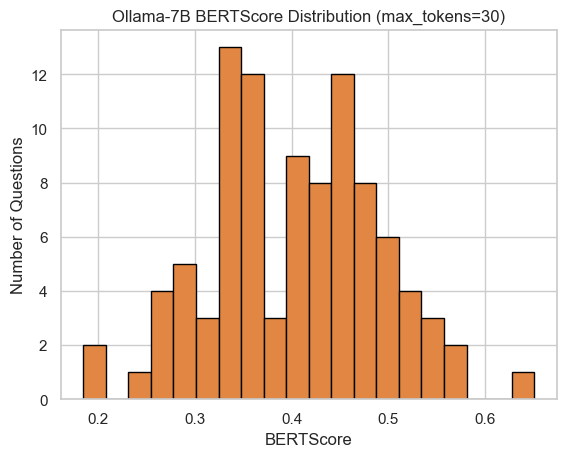

In [28]:
plt.hist(df_trial["bertscore_max_tokens30"], bins=20, color='#e28743', edgecolor='black')
plt.title("Ollama-7B BERTScore Distribution (max_tokens=30)")
plt.xlabel("BERTScore")
plt.ylabel("Number of Questions")
plt.grid(True)
plt.show()

* max_tokens=40

In [29]:
custom_ask = partial(ask_ollama, temperature=0.7, top_p=0.7, max_tokens=40)

with ThreadPoolExecutor(max_workers=8) as executor:
    df_trial["generated_max_tokens40"] = list(executor.map(custom_ask, df_trial["Question"]))

df_trial["bertscore_max_tokens40"] = [
    score_and_print(ref, gen)
    for ref, gen in zip(df_trial["Answer"], df_trial["generated_max_tokens40"])
]

Prompt: What is the typical structure of a deep learning research paper?
Generated: A typical structure of a deep learning research paper includes an introduction, literature review, methodology, results, discussion, and conclusion sections. The introduction provides background information and motivation for the study, while the literature review surveys existing work in the field. The methodology section details the dataset, models, and algorithms used, and the results section presents the findings of the study. The discussion section interprets the results and compares them to relevant work, and the conclusion summarizes the main findings and potential future directions.

Prompt: What are key considerations when selecting datasets for deep learning research?
Generated: When selecting datasets for deep learning research, key considerations include the size and diversity of the dataset, the quality and representativeness of the data, the availability of annotations or labels, and the c

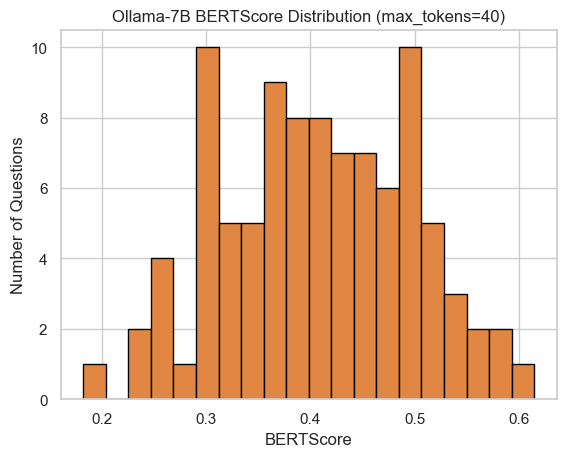

In [30]:
plt.hist(df_trial["bertscore_max_tokens40"], bins=20, color='#e28743', edgecolor='black')
plt.title("Ollama-7B BERTScore Distribution (max_tokens=40)")
plt.xlabel("BERTScore")
plt.ylabel("Number of Questions")
plt.grid(True)
plt.show()

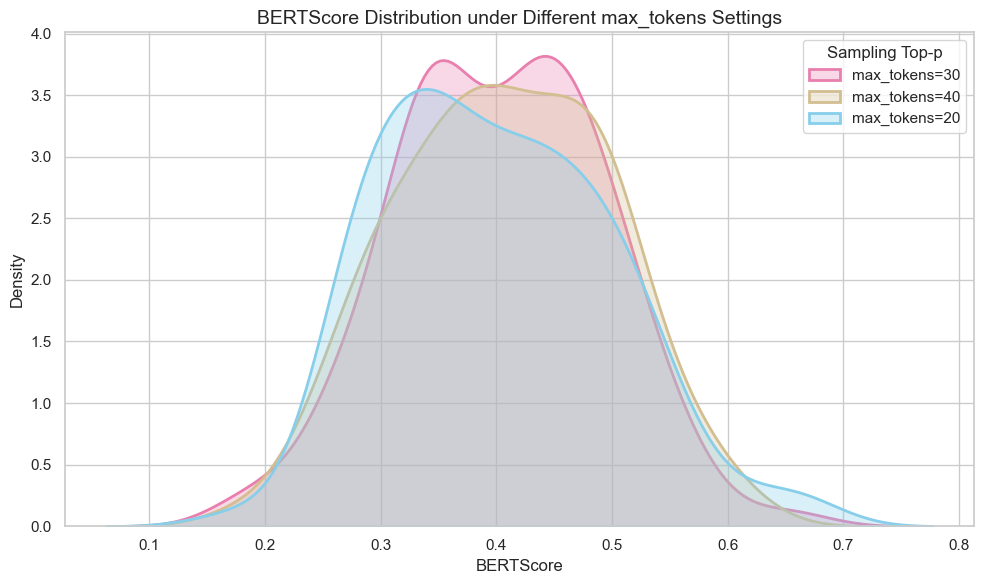

In [31]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))

sns.kdeplot(df_trial["bertscore_max_tokens30"], label="max_tokens=30", linewidth=2, fill=True, alpha=0.3, color='#e97faf')
sns.kdeplot(df_trial["bertscore_max_tokens40"], label="max_tokens=40", linewidth=2, fill=True, alpha=0.3, color='#d2be91')
sns.kdeplot(df_trial["bertscore_temp07_topp07"], label="max_tokens=20", linewidth=2, fill=True, alpha=0.3, color='skyblue')

plt.title("BERTScore Distribution under Different max_tokens Settings", fontsize=14)
plt.xlabel("BERTScore", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(title="Sampling Top-p")
plt.tight_layout()
plt.grid(True)

plt.show()

### 5.2 Penalty tuning

In [32]:
def best_llama2(prompt, model="llama2", repeat_penalty=1.1,max_tokens=20):
    url = "http://localhost:11434/api/chat"
    headers = {'Content-Type': 'application/json'}

    short_prompt = "Given that you are a researcher " + prompt.strip() + " Please keep your answer as concise as one or two sentences."

    payload = {
        "model": model,
        "messages": [
            {"role": "user", "content": short_prompt}
        ],
        "temperature": 0.7,
        "top_p": 0.7,
        "repeat_penalty": repeat_penalty,
        "stream": False,
        "num_predict": max_tokens
    }

    response = requests.post(url, json=payload, headers=headers)
    
    if response.status_code != 200:
        print("Error:", response.text)
        return ""

    result = response.json()["message"]["content"].strip()
    print(f"Prompt: {prompt}")
    print(f"Generated: {result}\n")
    return result

* repeat_penalty=1.5

In [33]:
custom_ask = partial(best_llama2, repeat_penalty=1.5)

with ThreadPoolExecutor(max_workers=8) as executor:
    df_trial["generated_penalty15"] = list(executor.map(custom_ask, df_trial["Question"]))

df_trial["bertscore_penalty15"] = [
    score_and_print(ref, gen)
    for ref, gen in zip(df_trial["Answer"], df_trial["generated_penalty15"])
]

Prompt: What are key considerations when selecting datasets for deep learning research?
Generated: When selecting datasets for deep learning research, there are several key considerations to keep in mind. Firstly, the dataset should be representative of the problem you are trying to solve and contain a sufficient amount of diverse data points to train a robust model. Additionally, the dataset should be well-documented, with clear information on how it was collected and any preprocessing or normalization that may have been applied.

Prompt: What are some best practices for writing the introduction of a deep learning paper?
Generated: As a researcher, some best practices for writing the introduction of a deep learning paper include:

1. Providing context and background information on the problem you are addressing, including any relevant literature review or state-of-the-art techniques.
2. Clearly stating the research question(s) or hypothesis being addressed, and how your proposed appro

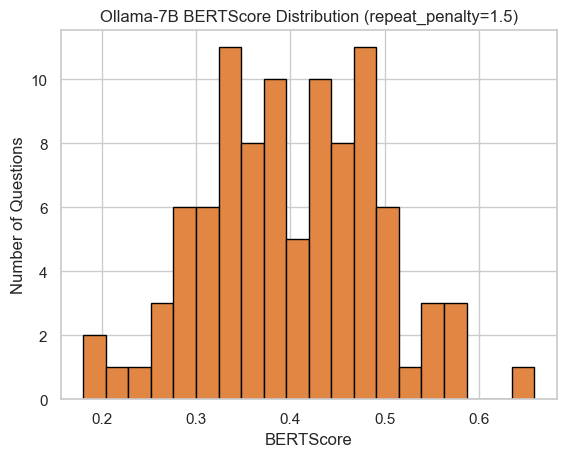

In [34]:
plt.hist(df_trial["bertscore_penalty15"], bins=20, color='#e28743', edgecolor='black')
plt.title("Ollama-7B BERTScore Distribution (repeat_penalty=1.5)")
plt.xlabel("BERTScore")
plt.ylabel("Number of Questions")
plt.grid(True)
plt.show()

* repeat_penalty=2.0

In [35]:
custom_ask = partial(best_llama2, repeat_penalty=2)

with ThreadPoolExecutor(max_workers=8) as executor:
    df_trial["generated_penalty2"] = list(executor.map(custom_ask, df_trial["Question"]))

df_trial["bertscore_penalty2"] = [
    score_and_print(ref, gen)
    for ref, gen in zip(df_trial["Answer"], df_trial["generated_penalty2"])
]

Prompt: What are some best practices for writing the introduction of a deep learning paper?
Generated: As a researcher, some best practices for writing the introduction of a deep learning paper include providing a clear and concise background and context for the problem being addressed, stating the research question or hypothesis, and outlining the objectives and scope of the paper. Additionally, it's important to provide a brief overview of the methodology and main contributions of the paper.

Prompt: What are key considerations when selecting datasets for deep learning research?
Generated: When selecting datasets for deep learning research, key considerations include the size and diversity of the dataset, the quality and availability of labeled data, the representativeness of the data to the problem being addressed, and the compatibility of the dataset with the chosen algorithms and models. Additionally, it is important to evaluate the dataset's bias and ethical implications, as well

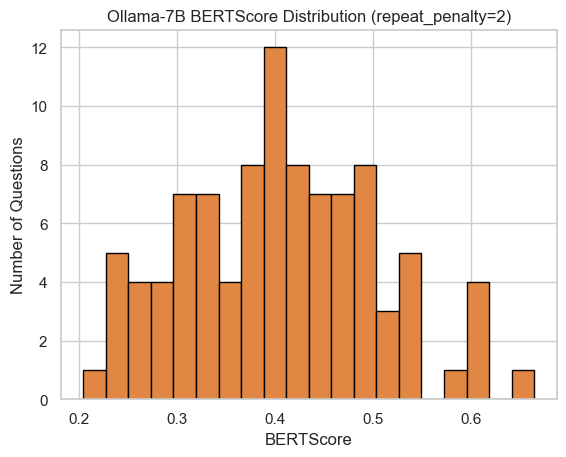

In [36]:
plt.hist(df_trial["bertscore_penalty2"], bins=20, color='#e28743', edgecolor='black')
plt.title("Ollama-7B BERTScore Distribution (repeat_penalty=2)")
plt.xlabel("BERTScore")
plt.ylabel("Number of Questions")
plt.grid(True)
plt.show()

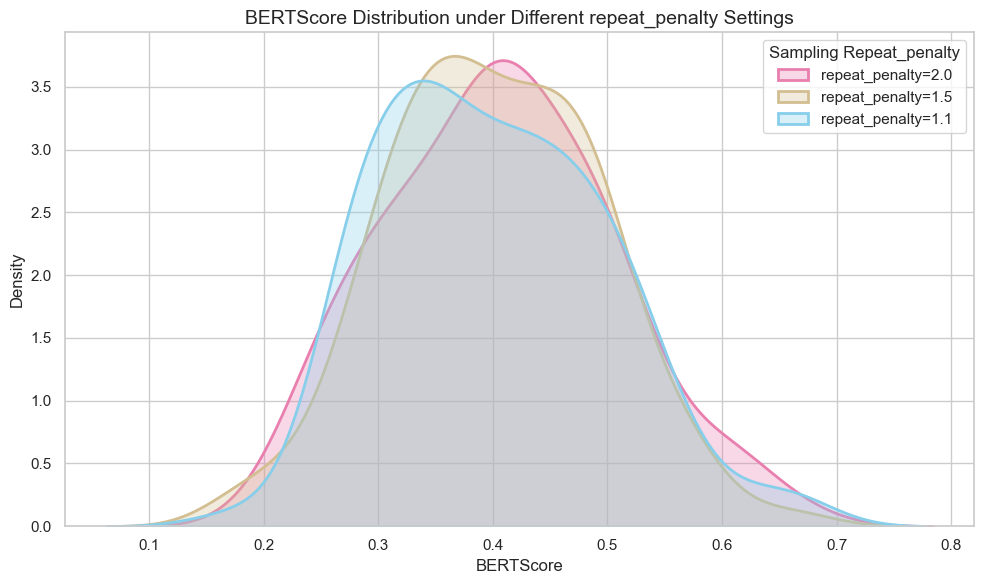

In [37]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))

sns.kdeplot(df_trial["bertscore_penalty2"], label="repeat_penalty=2.0", linewidth=2, fill=True, alpha=0.3, color='#e97faf')
sns.kdeplot(df_trial["bertscore_penalty15"], label="repeat_penalty=1.5", linewidth=2, fill=True, alpha=0.3, color='#d2be91')
sns.kdeplot(df_trial["bertscore_temp07_topp07"], label="repeat_penalty=1.1", linewidth=2, fill=True, alpha=0.3, color='skyblue')

plt.title("BERTScore Distribution under Different repeat_penalty Settings", fontsize=14)
plt.xlabel("BERTScore", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(title="Sampling Repeat_penalty")
plt.tight_layout()
plt.grid(True)

plt.show()

In [38]:
df_trial.to_csv("qa_final.csv")